In [1]:
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import random

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
# from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.python.client import device_lib

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.1


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


In [6]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16976555092746844704
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5750390784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 950544156385922541
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
seed_val = 43

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed_val)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(seed_val)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed_val)

## EDA Functions

In [10]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [11]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [12]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Load Data

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

## EDA

In [14]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


In [15]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


In [16]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [17]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

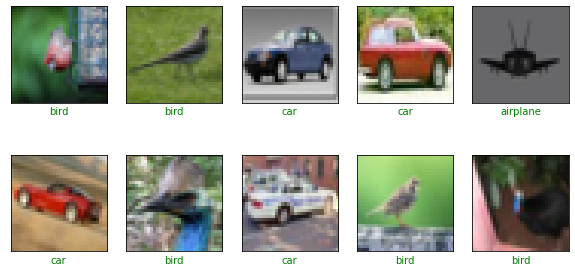

In [196]:
class_names_preview = ['airplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

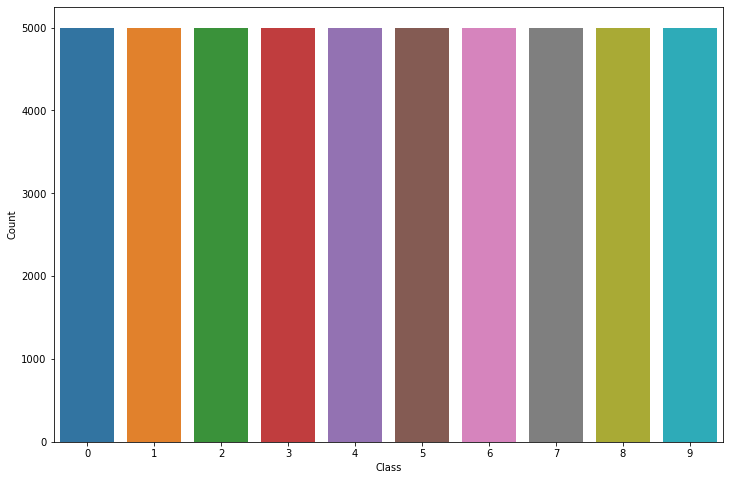

In [19]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(train_labels.ravel()).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [20]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [21]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=seed_val
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [22]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [23]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

# STOP SETUP HERE

## Experiment 5

- DNN with 2 layers (384, 768)
- Batch Normalization
- L2 Regularization(0.001)

In [172]:
k.clear_session()
model_05 = Sequential([
   Flatten(input_shape=x_train_norm.shape[1:]),
   Dense(units=384,activation=tf.nn.relu),
#   Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
   BatchNormalization(),
#   Dropout(0.3),
   Dense(units=768,activation=tf.nn.relu),
#   Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
   BatchNormalization(),
#   Dropout(0.3),
   Dense(units=10, activation=tf.nn.softmax)       
])


In [173]:
model_05.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 384)               1180032   
                                                                 
 batch_normalization (BatchN  (None, 384)              1536      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 batch_normalization_1 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 10)                7

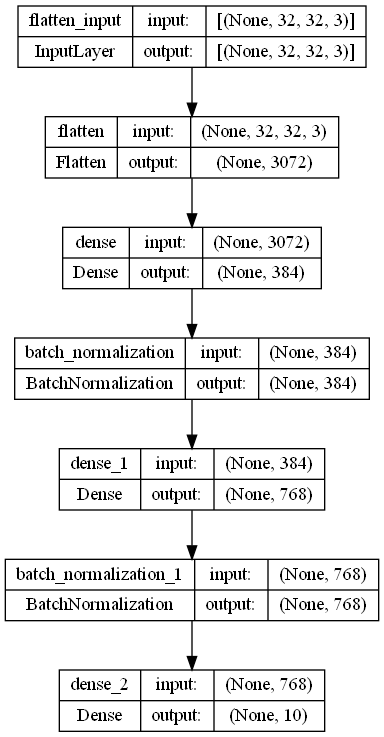

In [174]:
keras.utils.plot_model(model_05, "CIFAR10_EXP_05.png", show_shapes=True) 

In [175]:
model_05.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [176]:
history_05 = model_05.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_05_2DNN_BN.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 11s 14ms/step - loss: 1.7868 - accuracy: 0.3777 - val_loss: 1.7596 - val_accuracy: 0.3900
Epoch 2/200
704/704 [==============================] - 5s 8ms/step - loss: 1.6192 - accuracy: 0.4288 - val_loss: 2.1764 - val_accuracy: 0.3118
Epoch 3/200
704/704 [==============================] - 5s 7ms/step - loss: 1.5274 - accuracy: 0.4596 - val_loss: 1.7475 - val_accuracy: 0.3950
Epoch 4/200
704/704 [==============================] - 5s 7ms/step - loss: 1.4654 - accuracy: 0.4854 - val_loss: 2.1771 - val_accuracy: 0.3342
Epoch 5/200
704/704 [==============================] - 5s 7ms/step - loss: 1.4230 - accuracy: 0.4970 - val_loss: 1.8804 - val_accuracy: 0.3908
Epoch 6/200
704/704 [==============================] - 5s 7ms/step - loss: 1.3650 - accuracy: 0.5182 - val_loss: 1.6271 - val_accuracy: 0.4516
Epoch 7/200
704/704 [==============================] - 4s 6ms/step - loss: 1.3165 - accuracy: 0.5340 - val_loss: 1.6905 - val_accuracy: 0.43

In [29]:
# model_05 = tf.keras.models.load_model("A2_Exp_05_2DNN_BN.h5") # batch normalization - best model?
# print(f"Test acc: {model_05.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 1.4702 - accuracy: 0.5259
Test acc: 0.526


In [35]:
# model_05 = tf.keras.models.load_model("A2_Exp_05_2DNN_L2REG.h5") #  L2 reg 0.001
# print(f"Test acc: {model_05.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 1.5561 - accuracy: 0.4886
Test acc: 0.489


In [44]:
# model_05 = tf.keras.models.load_model("A2_Exp_05_2DNN_L2REG.h5") #  dropout 0.3
# print(f"Test acc: {model_05.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.7009 - accuracy: 0.4220
Test acc: 0.422


In [50]:
# model_05 = tf.keras.models.load_model("A2_Exp_05_2DNN_L2REG.h5") # batch normalization, L2 reg 0.001
# print(f"Test acc: {model_05.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 1.6672 - accuracy: 0.4621
Test acc: 0.462


In [56]:
model_05 = tf.keras.models.load_model("A2_Exp_05_2DNN_L2REG.h5") # batch normalization, L2 reg 0.001, dropout 0.3
print(f"Test acc: {model_05.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 1.7579 - accuracy: 0.4021
Test acc: 0.402


In [177]:
model_05 = tf.keras.models.load_model("A2_Exp_05_2DNN_BN.h5") # batch normalization - best model?
print(f"Test acc: {model_05.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.4786 - accuracy: 0.4924
Test acc: 0.492


In [178]:
pred05 = model_05.predict(x_test_norm)
print('shape of preds: ', pred05.shape)

313/313 [==============================] - 1s 2ms/step
shape of preds:  (10000, 10)


In [179]:
history_05_dict = history_05.history
history_05_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [180]:
history_05_df=pd.DataFrame(history_05_dict)
history_05_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
39,0.700,0.750,2.054,0.477
40,0.697,0.751,2.016,0.491
41,0.679,0.758,2.063,0.477
42,0.670,0.760,1.998,0.483
43,0.662,0.764,2.144,0.465


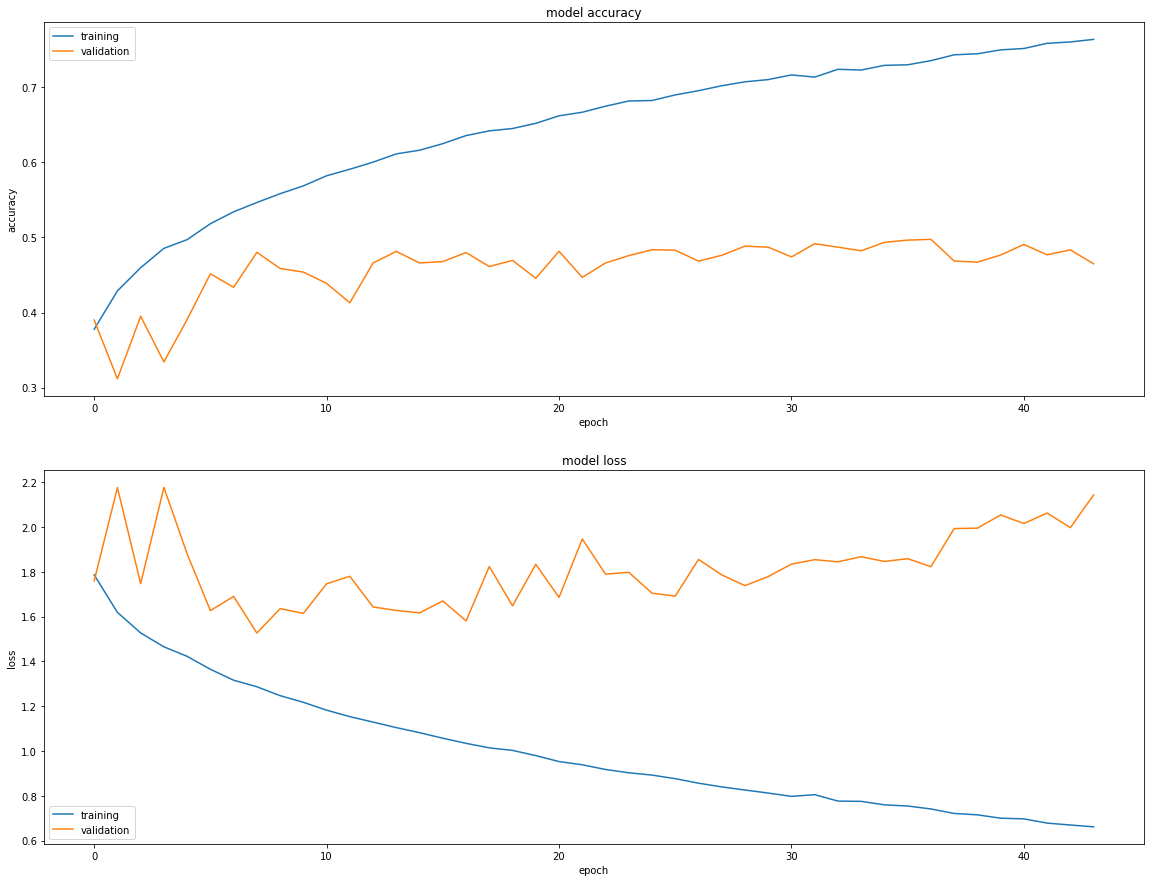

In [181]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_05.history['accuracy'], history_05.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_05.history['loss'], history_05.history['val_loss'], 'loss', 212)

In [182]:
pred05_cm=np.argmax(pred05, axis=1)
print_validation_report(y_test, pred05_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.53      0.61      0.57      1000
           1       0.45      0.75      0.56      1000
           2       0.45      0.30      0.36      1000
           3       0.36      0.24      0.29      1000
           4       0.39      0.52      0.45      1000
           5       0.48      0.38      0.42      1000
           6       0.59      0.47      0.52      1000
           7       0.55      0.56      0.55      1000
           8       0.66      0.54      0.59      1000
           9       0.50      0.57      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.50      0.49      0.48     10000
weighted avg       0.50      0.49      0.48     10000

Accuracy Score: 0.4924
Root Mean Square Error: 3.1760824926314495


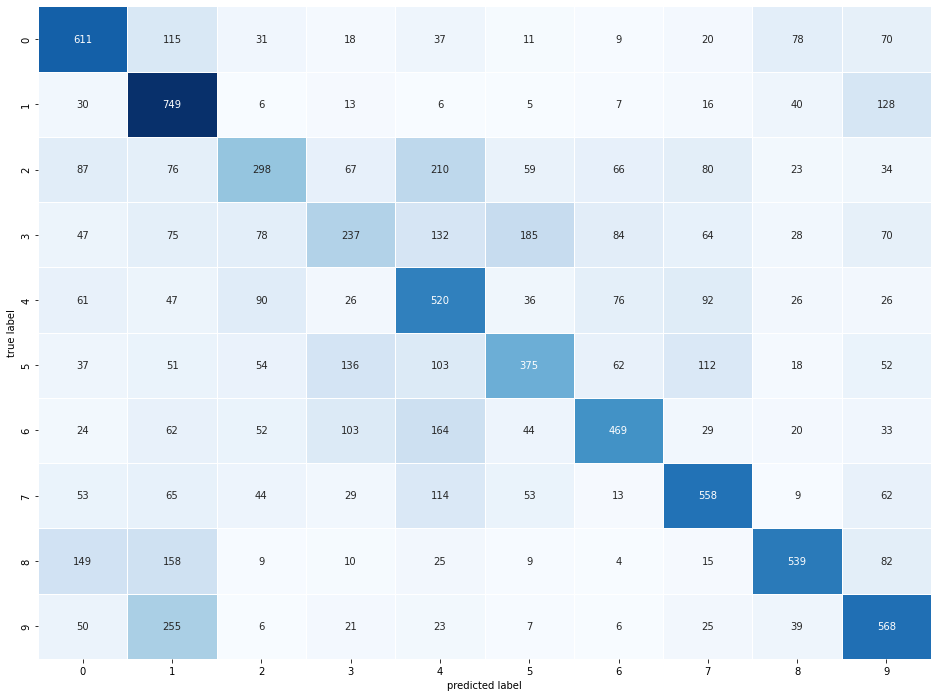

In [183]:
plot_confusion_matrix(y_test,pred05_cm)

In [184]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred05[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,7.24%,21.54%,3.03%,26.36%,13.19%,19.56%,0.31%,0.02%,7.66%,1.10%
1,1.89%,60.70%,0.00%,0.21%,0.04%,0.02%,0.00%,0.13%,14.12%,22.87%
2,43.40%,29.06%,0.22%,0.02%,0.07%,0.01%,0.00%,0.05%,11.73%,15.43%
3,33.75%,13.62%,1.42%,2.33%,4.06%,0.46%,0.02%,3.42%,38.46%,2.46%
4,0.22%,0.24%,6.35%,1.23%,71.07%,3.57%,16.52%,0.34%,0.24%,0.22%
5,2.01%,0.99%,2.59%,11.38%,7.63%,12.90%,60.22%,1.88%,0.20%,0.20%
6,1.36%,85.49%,0.32%,8.25%,0.00%,1.54%,0.03%,0.02%,0.11%,2.88%
7,1.27%,1.71%,4.12%,3.47%,4.51%,0.90%,80.72%,0.11%,0.27%,2.92%
8,7.26%,0.95%,10.96%,11.05%,41.84%,10.95%,0.38%,15.26%,0.83%,0.51%
9,3.00%,84.28%,0.39%,0.46%,2.88%,0.05%,0.02%,0.06%,6.18%,2.68%


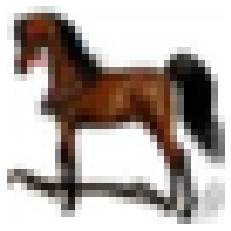

In [185]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [186]:
layer_names = []
for layer in model_05.layers:
    layer_names.append(layer.name)
    
layer_names

['flatten',
 'dense',
 'batch_normalization',
 'dense_1',
 'batch_normalization_1',
 'dense_2']

In [187]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_05.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model_05 = tf.keras.models.Model(inputs=model_05.input, outputs=layer_outputs)

# Get activation values for the last dense layer
# activations_05 = activation_model_05.predict(x_valid_norm[:3250])
activations_05 = activation_model_05.predict(x_valid_norm[:1500])
dense_layer_activations_05 = activations_05[-3]
output_layer_activations_05 = activations_05[-1]

47/47 [==============================] - 0s 3ms/step


In [188]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_05 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_05 = tsne_05.fit_transform(dense_layer_activations_05)

# Scaling
tsne_results_05 = (tsne_results_05 - tsne_results_05.min()) / (tsne_results_05.max() - tsne_results_05.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 4.697889


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.257202
[t-SNE] KL divergence after 300 iterations: 1.542176


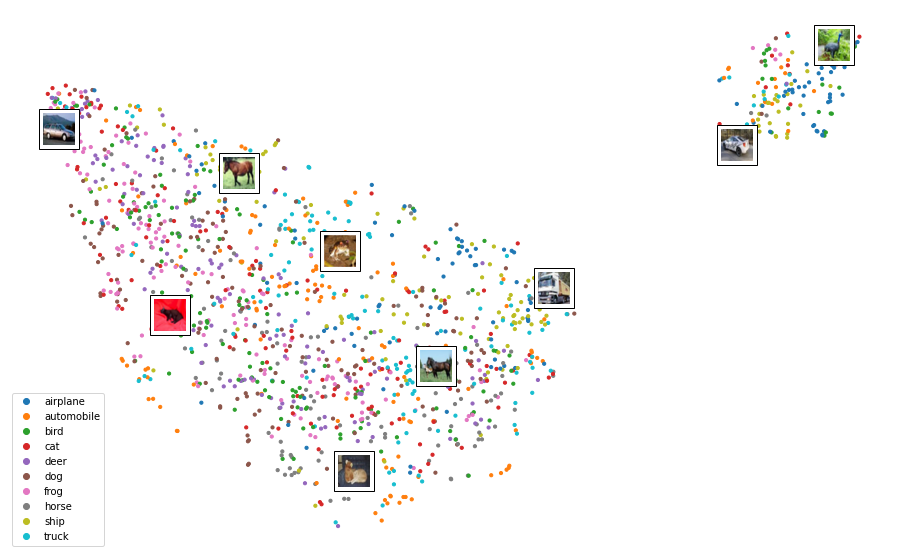

In [189]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_05[:,0],tsne_results_05[:,1], c=y_valid_split[:1500], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_05):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 6

- DNN with 3 layers
- Regularization: batch normalization

In [190]:
k.clear_session()
model_06 = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=384,activation=tf.nn.relu),
  BatchNormalization(),
  Dense(units=768,activation=tf.nn.relu),
  BatchNormalization(),
  Dense(units=1536,activation=tf.nn.relu),
  BatchNormalization(),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [191]:
model_06.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 384)               1180032   
                                                                 
 batch_normalization (BatchN  (None, 384)              1536      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 batch_normalization_1 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1536)              1

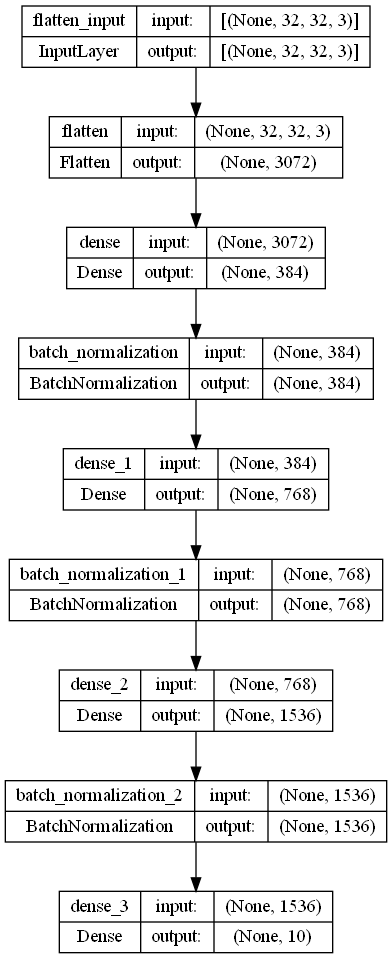

In [192]:
keras.utils.plot_model(model_06, "CIFAR10_EXP_06.png", show_shapes=True) 

In [193]:
model_06.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [194]:
history_06 = model_06.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_06_3DNN_BN.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 9ms/step - loss: 1.8798 - accuracy: 0.3601 - val_loss: 2.1570 - val_accuracy: 0.2864
Epoch 2/200
704/704 [==============================] - 6s 8ms/step - loss: 1.6756 - accuracy: 0.4165 - val_loss: 2.0708 - val_accuracy: 0.3122
Epoch 3/200
704/704 [==============================] - 6s 9ms/step - loss: 1.5781 - accuracy: 0.4470 - val_loss: 1.9878 - val_accuracy: 0.3524
Epoch 4/200
704/704 [==============================] - 6s 8ms/step - loss: 1.5158 - accuracy: 0.4738 - val_loss: 2.0254 - val_accuracy: 0.3612
Epoch 5/200
704/704 [==============================] - 6s 8ms/step - loss: 1.4570 - accuracy: 0.4923 - val_loss: 1.8684 - val_accuracy: 0.3700
Epoch 6/200
704/704 [==============================] - 6s 8ms/step - loss: 1.3790 - accuracy: 0.5156 - val_loss: 1.9158 - val_accuracy: 0.4140
Epoch 7/200
704/704 [==============================] - 6s 8ms/step - loss: 1.3266 - accuracy: 0.5399 - val_loss: 1.6865 - val_accuracy: 0.4290

In [195]:
model_06 = tf.keras.models.load_model("A2_Exp_06_3DNN_BN.h5")
print(f"Test acc: {model_06.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 1.5122 - accuracy: 0.4937
Test acc: 0.494


In [91]:
pred06 = model_06.predict(x_test_norm)
print('shape of preds: ', pred06.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


In [92]:
history_06_dict = history_06.history
history_06_df=pd.DataFrame(history_06_dict)
history_06_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
14,0.915,0.674,1.744,0.457
15,0.879,0.686,1.632,0.486
16,0.849,0.696,1.609,0.488
17,0.821,0.707,1.799,0.473
18,0.785,0.720,1.842,0.454


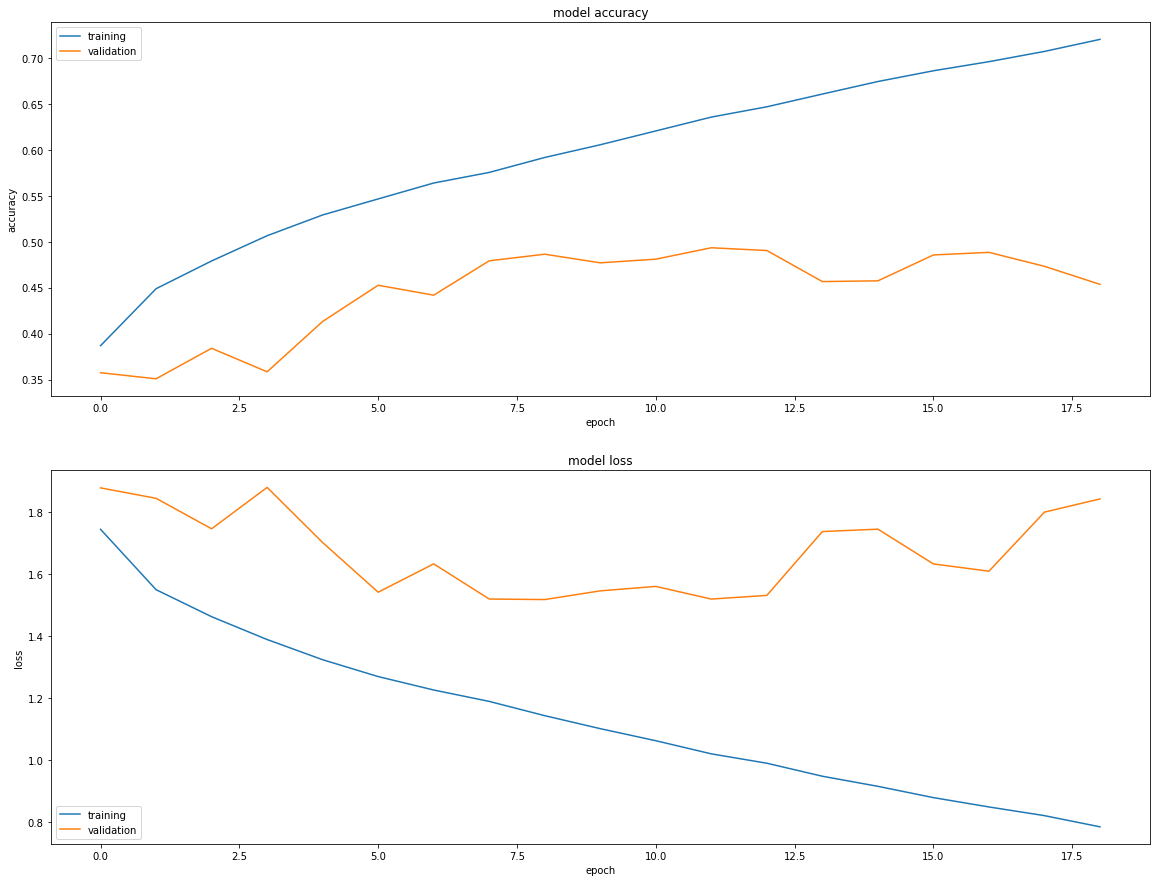

In [93]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_06.history['accuracy'], history_06.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_06.history['loss'], history_06.history['val_loss'], 'loss', 212)

In [94]:
pred06_cm=np.argmax(pred06, axis=1)
print_validation_report(y_test, pred06_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.43      0.52      1000
           1       0.78      0.38      0.51      1000
           2       0.39      0.40      0.39      1000
           3       0.31      0.44      0.36      1000
           4       0.45      0.46      0.45      1000
           5       0.46      0.29      0.36      1000
           6       0.55      0.55      0.55      1000
           7       0.57      0.56      0.56      1000
           8       0.54      0.65      0.59      1000
           9       0.45      0.70      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.52      0.49      0.49     10000
weighted avg       0.52      0.49      0.49     10000

Accuracy Score: 0.4869
Root Mean Square Error: 3.1801257836758596


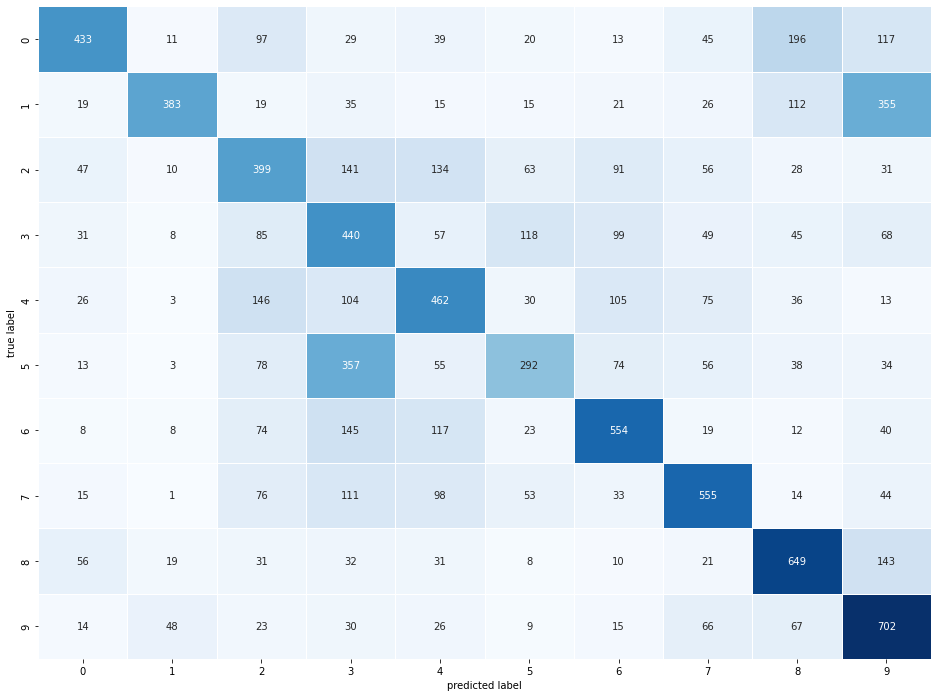

In [95]:
plot_confusion_matrix(y_test,pred06_cm)

In [96]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred06[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.29%,1.72%,1.49%,69.78%,7.59%,13.98%,0.81%,0.69%,2.25%,1.40%
1,1.09%,3.21%,0.58%,0.05%,0.07%,0.02%,0.01%,0.44%,16.70%,77.83%
2,9.03%,4.28%,0.77%,0.07%,0.46%,0.12%,0.01%,0.84%,74.14%,10.29%
3,8.83%,1.15%,8.36%,0.29%,3.50%,0.45%,0.01%,1.38%,70.83%,5.20%
4,0.02%,0.00%,1.54%,9.48%,54.40%,2.68%,31.78%,0.05%,0.05%,0.00%
5,6.93%,0.20%,1.12%,8.53%,5.27%,3.67%,71.90%,1.38%,0.55%,0.46%
6,0.23%,50.00%,0.61%,41.40%,0.00%,3.61%,2.17%,0.74%,0.81%,0.42%
7,5.42%,5.16%,11.39%,0.69%,3.87%,0.42%,62.15%,0.08%,0.45%,10.38%
8,1.42%,0.03%,26.59%,12.37%,12.97%,42.22%,0.21%,3.28%,0.69%,0.23%
9,0.35%,35.61%,0.27%,0.41%,0.51%,0.07%,0.03%,0.03%,2.68%,60.04%


In [97]:
layer_names = []
for layer in model_06.layers:
    layer_names.append(layer.name)
    
layer_names

['flatten',
 'dense',
 'batch_normalization',
 'dense_1',
 'batch_normalization_1',
 'dense_2',
 'batch_normalization_2',
 'dense_3']

In [98]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_06.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_06 = tf.keras.models.Model(inputs=model_06.input, outputs=layer_outputs)

# Get activation values for the last dense layer
# activations_06 = activation_model_06.predict(x_valid_norm[:3250])
activations_06 = activation_model_06.predict(x_valid_norm[:1500])
dense_layer_activations_06 = activations_06[-3]
output_layer_activations_06 = activations_06[-1]

47/47 [==============================] - 0s 3ms/step


In [99]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_06 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_06 = tsne_06.fit_transform(dense_layer_activations_06)

# Scaling
tsne_results_06 = (tsne_results_06 - tsne_results_06.min()) / (tsne_results_06.max() - tsne_results_06.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 10.963113


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.158691
[t-SNE] KL divergence after 300 iterations: 1.781456


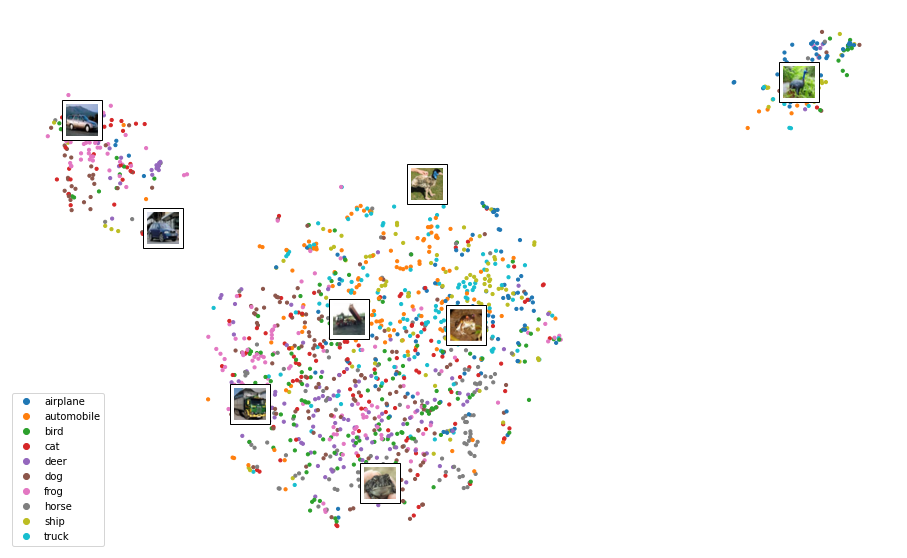

In [100]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_06[:,0],tsne_results_06[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_06[:,0],tsne_results_06[:,1], c=y_valid_split[:1500], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_06):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 7

- CNN with 2 layers/max pooling layers
- L2 Regularization(0.001)

In [125]:
k.clear_session()
model_07 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
#  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
#  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu),
#  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
#  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [126]:
model_07.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 384)               3

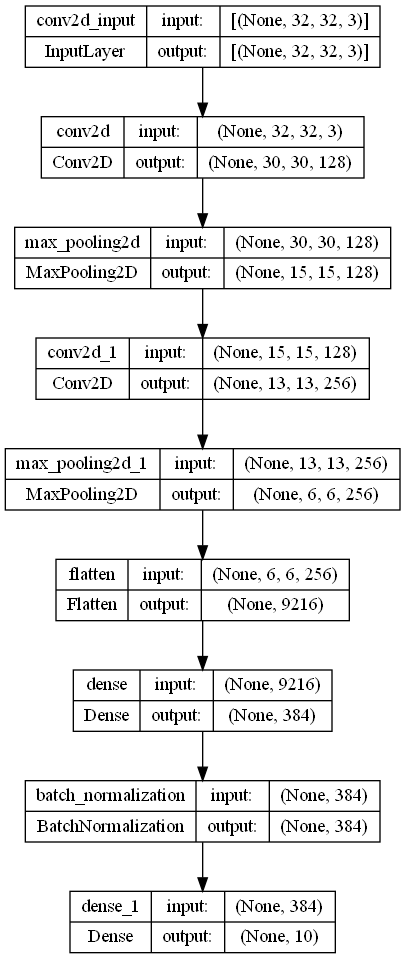

In [127]:
keras.utils.plot_model(model_07, "CIFAR10_EXP_07.png", show_shapes=True) 

In [128]:
model_07.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [129]:
history_07 = model_07.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_07_2CNN_BN.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 7s 9ms/step - loss: 1.2698 - accuracy: 0.5578 - val_loss: 1.1777 - val_accuracy: 0.5788
Epoch 2/200
704/704 [==============================] - 6s 8ms/step - loss: 0.9820 - accuracy: 0.6602 - val_loss: 1.5646 - val_accuracy: 0.5114
Epoch 3/200
704/704 [==============================] - 6s 8ms/step - loss: 0.8449 - accuracy: 0.7076 - val_loss: 1.0481 - val_accuracy: 0.6356
Epoch 4/200
704/704 [==============================] - 6s 8ms/step - loss: 0.7421 - accuracy: 0.7449 - val_loss: 0.9733 - val_accuracy: 0.6676
Epoch 5/200
704/704 [==============================] - 6s 8ms/step - loss: 0.6577 - accuracy: 0.7720 - val_loss: 1.0397 - val_accuracy: 0.6538
Epoch 6/200
704/704 [==============================] - 6s 8ms/step - loss: 0.5721 - accuracy: 0.7991 - val_loss: 0.9350 - val_accuracy: 0.6934
Epoch 7/200
704/704 [==============================] - 6s 8ms/step - loss: 0.4961 - accuracy: 0.8249 - val_loss: 0.9545 - val_accuracy: 0.6990

In [130]:
model_07 = tf.keras.models.load_model("A2_Exp_07_2CNN_BN.h5") # Batch normalization
print(f"Test acc: {model_07.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.9417 - accuracy: 0.6958
Test acc: 0.696


In [112]:
# model_07 = tf.keras.models.load_model("A2_Exp_07_2CNN_BN_L2.h5") # Batch normalization, l2 reg 0.001
# print(f"Test acc: {model_07.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.5188 - accuracy: 0.6728
Test acc: 0.673


In [58]:
# model_07 = tf.keras.models.load_model("A2_Exp_07_2CNN_DO_L2_BN.h5") # dropout 0.03, l2 reg 0.001, Batch normalization
# print(f"Test acc: {model_07.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.0481 - accuracy: 0.7839
Test acc: 0.784


In [131]:
pred07 = model_07.predict(x_test_norm)
print('shape of preds: ', pred07.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


In [132]:
history_07_dict = history_07.history
history_07_df=pd.DataFrame(history_07_dict)
history_07_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
47,0.015,0.996,1.927,0.711
48,0.023,0.992,1.939,0.716
49,0.031,0.989,1.934,0.712
50,0.023,0.993,1.964,0.705
51,0.036,0.988,1.964,0.723


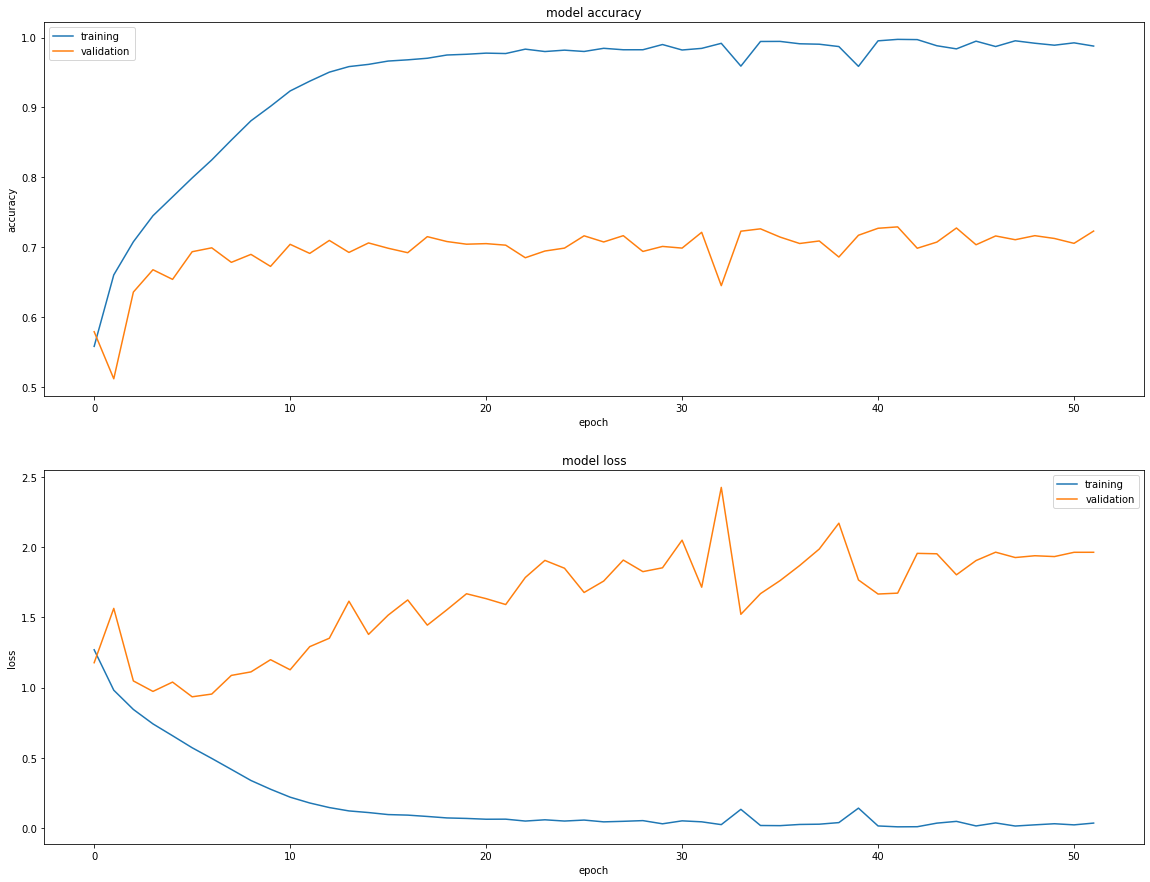

In [133]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_07.history['accuracy'], history_07.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_07.history['loss'], history_07.history['val_loss'], 'loss', 212)

In [134]:
pred07_cm=np.argmax(pred07, axis=1)
print_validation_report(y_test, pred07_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.81      0.75      1000
           1       0.81      0.84      0.83      1000
           2       0.49      0.70      0.58      1000
           3       0.62      0.43      0.51      1000
           4       0.71      0.58      0.64      1000
           5       0.56      0.69      0.62      1000
           6       0.69      0.84      0.76      1000
           7       0.91      0.56      0.69      1000
           8       0.86      0.78      0.82      1000
           9       0.85      0.73      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.72      0.70      0.70     10000
weighted avg       0.72      0.70      0.70     10000

Accuracy Score: 0.6958
Root Mean Square Error: 2.2870286399605932


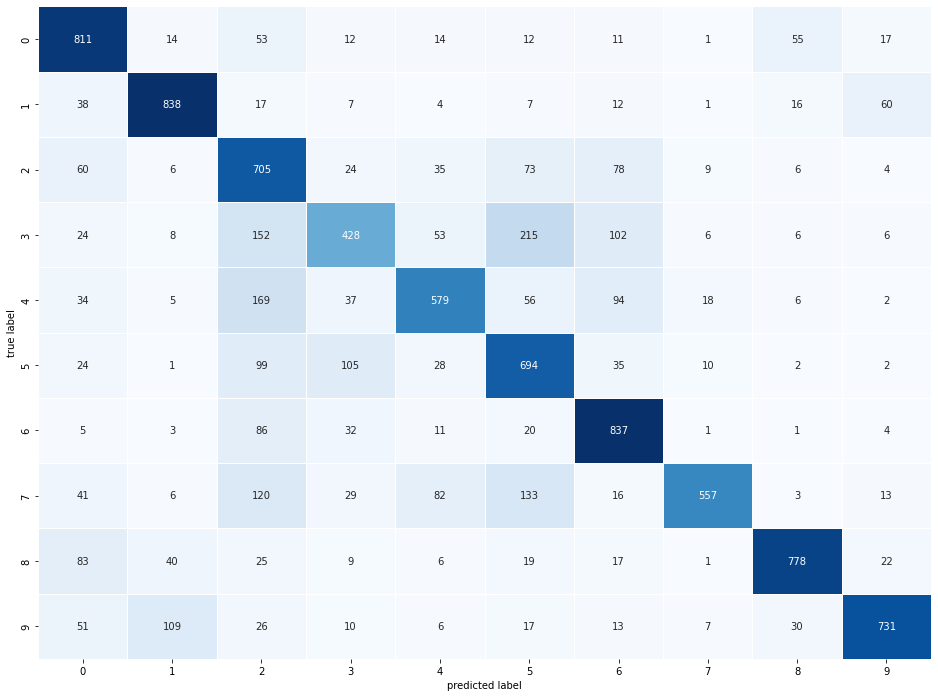

In [135]:
plot_confusion_matrix(y_test,pred07_cm)

In [136]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred07[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.05%,0.00%,0.02%,84.77%,0.00%,2.32%,12.79%,0.00%,0.04%,0.00%
1,5.17%,6.80%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,87.99%,0.03%
2,9.94%,10.46%,0.30%,0.28%,2.01%,0.17%,0.05%,0.42%,72.10%,4.27%
3,11.19%,0.02%,0.49%,0.01%,0.02%,0.00%,0.00%,0.01%,88.27%,0.00%
4,0.00%,0.00%,0.13%,0.36%,0.09%,0.03%,99.38%,0.00%,0.00%,0.00%
5,0.01%,0.00%,0.12%,1.85%,0.00%,0.60%,97.41%,0.00%,0.00%,0.00%
6,0.00%,99.38%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.62%
7,0.54%,0.00%,6.35%,0.86%,0.45%,0.11%,91.62%,0.01%,0.05%,0.01%
8,0.18%,0.01%,2.18%,88.69%,3.05%,3.01%,2.08%,0.79%,0.00%,0.01%
9,0.16%,97.15%,0.01%,0.00%,0.00%,0.00%,0.03%,0.00%,0.02%,2.63%


In [137]:
layer_names = []
for layer in model_07.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'batch_normalization',
 'dense_1']

In [138]:
# Extracts the outputs of the top 8 layers:
layer_outputs_07 = [layer.output for layer in model_07.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_07 = tf.keras.models.Model(inputs=model_07.input, outputs=layer_outputs_07)

# Get activation values for the last dense layer
# activations_07 = activation_model_07.predict(x_valid_norm[:3250])
activations_07 = activation_model_07.predict(x_valid_norm[:1200])
dense_layer_activations_07 = activations_07[-3]
output_layer_activations_07 = activations_07[-1]

38/38 [==============================] - 0s 8ms/step


In [139]:
dense_layer_activations_07.shape

(1200, 384)

In [140]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_07 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_07 = tsne_07.fit_transform(dense_layer_activations_07)

# Scaling
tsne_results_07 = (tsne_results_07 - tsne_results_07.min()) / (tsne_results_07.max() - tsne_results_07.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.001s...
[t-SNE] Computed neighbors for 1200 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 2.216252


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.553177
[t-SNE] KL divergence after 300 iterations: 1.653876


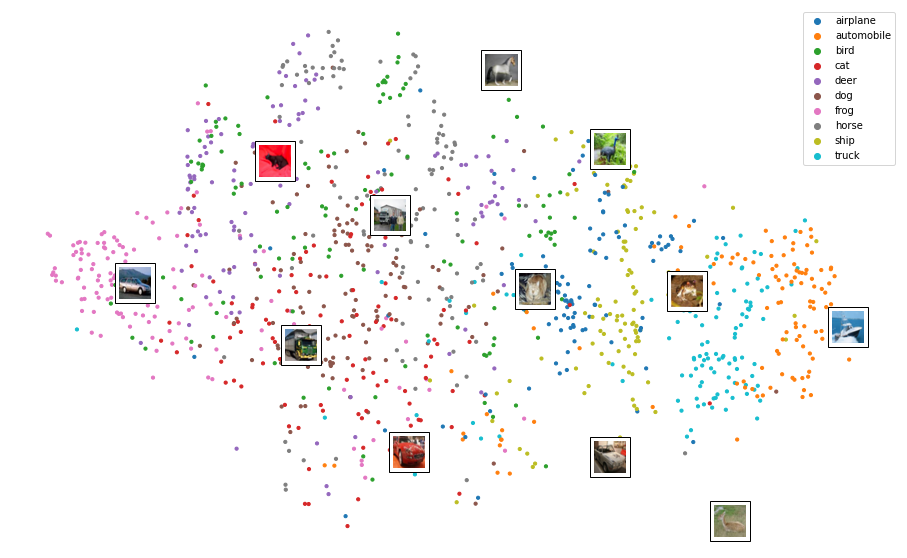

In [141]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_07[:,0],tsne_results_07[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_07[:,0],tsne_results_07[:,1], c=y_valid_split[:1200], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_07):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

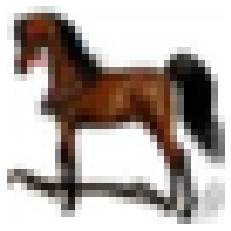

In [142]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [143]:
activations_cnn_07 = activation_model_07.predict(img_tensor)
len(activations_cnn_07)

1/1 [==============================] - 0s 13ms/step


8

C:\Users\Reed\AppData\Local\Temp\ipykernel_23184\4110578926.py:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


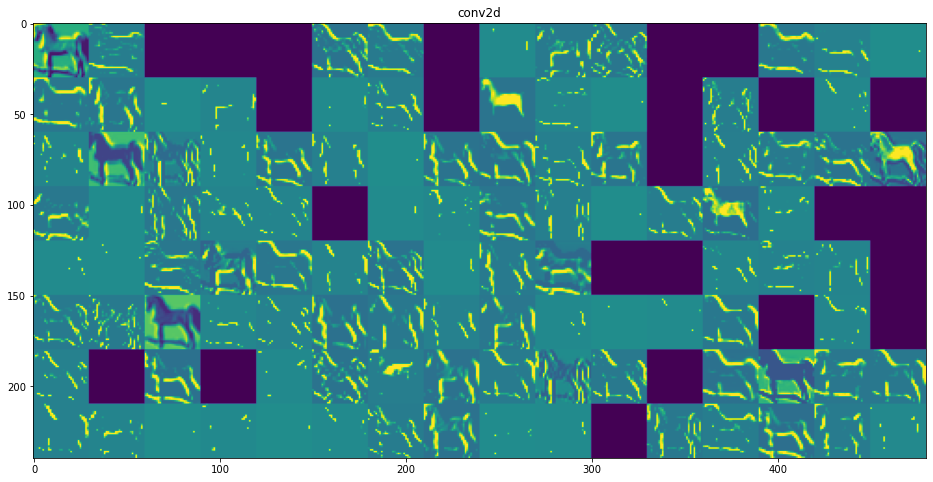

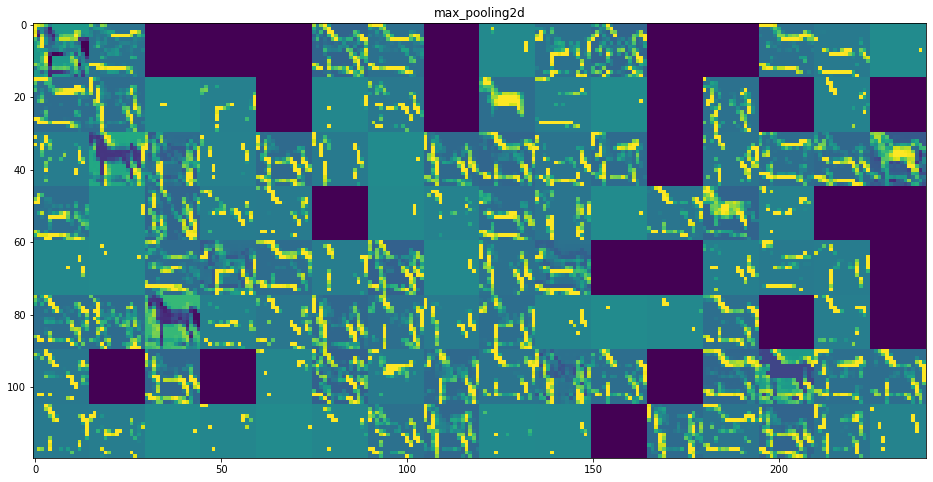

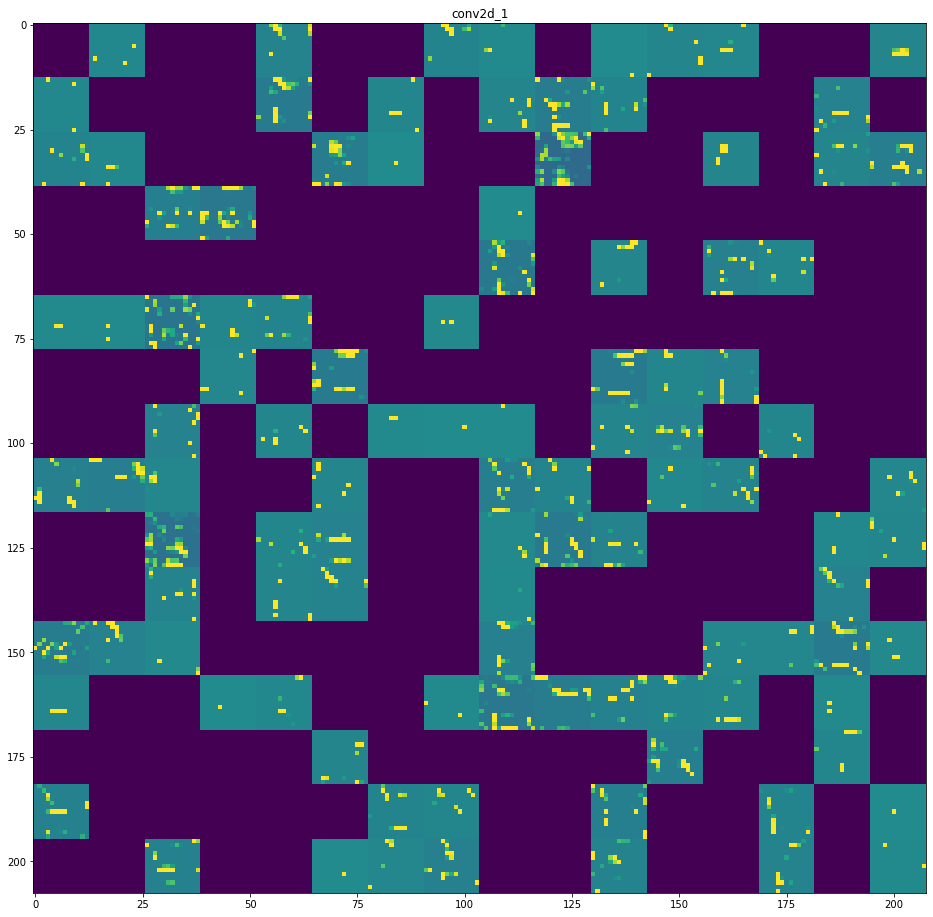

In [144]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_07.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_cnn_07):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

## Experiment 8

- CNN with 3 layers/max pooling layers
- L2 Regularization(0.001)

In [152]:
k.clear_session()
model_08 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
#  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
#  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
#  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu),
#  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
#  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [153]:
model_08.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 512)        0

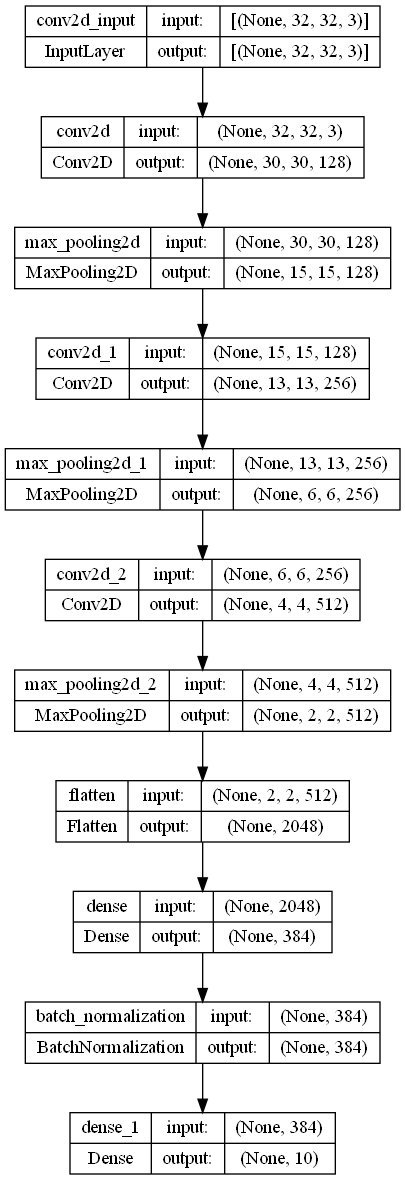

In [154]:
keras.utils.plot_model(model_08, "CIFAR10_EXP_08.png", show_shapes=True) 

In [155]:
model_08.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [156]:
history_08 = model_08.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_08_3CNN_BN.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 15s 17ms/step - loss: 1.2665 - accuracy: 0.5555 - val_loss: 1.4587 - val_accuracy: 0.5120
Epoch 2/200
704/704 [==============================] - 7s 10ms/step - loss: 0.9387 - accuracy: 0.6759 - val_loss: 2.2092 - val_accuracy: 0.4208
Epoch 3/200
704/704 [==============================] - 8s 11ms/step - loss: 0.7867 - accuracy: 0.7294 - val_loss: 1.0282 - val_accuracy: 0.6500
Epoch 4/200
704/704 [==============================] - 9s 13ms/step - loss: 0.6656 - accuracy: 0.7702 - val_loss: 0.8498 - val_accuracy: 0.7128
Epoch 5/200
704/704 [==============================] - 7s 11ms/step - loss: 0.5675 - accuracy: 0.8014 - val_loss: 0.9309 - val_accuracy: 0.6996
Epoch 6/200
704/704 [==============================] - 7s 11ms/step - loss: 0.4632 - accuracy: 0.8397 - val_loss: 0.9672 - val_accuracy: 0.7048
Epoch 7/200
704/704 [==============================] - 8s 11ms/step - loss: 0.3848 - accuracy: 0.8653 - val_loss: 0.9743 - val_accuracy

In [157]:
model_08 = tf.keras.models.load_model("A2_Exp_08_3CNN_BN.h5") # Batch Norm
print(f"Test acc: {model_08.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 0.8391 - accuracy: 0.7181
Test acc: 0.718


In [ ]:
# model_08 = tf.keras.models.load_model("A2_Exp_08_3CNN_BN_L2REG_DO.h5") # Batch Norm, L2 Reg(0.001), Dropout(0.3)
# print(f"Test acc: {model_08.evaluate(x_test_norm, y_test)[1]:.3f}")

In [ ]:
# model_08 = tf.keras.models.load_model("A2_Exp_08_3CNN_BN_L2REG_DO.h5") # Batch Norm, L2 Reg(0.001), Dropout(0.3)
# print(f"Test acc: {model_08.evaluate(x_test_norm, y_test)[1]:.3f}")

In [158]:
pred08 = model_08.predict(x_test_norm)
print('shape of preds: ', pred08.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


In [159]:
history_08_dict = history_08.history
history_08_df=pd.DataFrame(history_08_dict)
history_08_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
18,0.078,0.973,1.713,0.706
19,0.077,0.973,1.644,0.714
20,0.072,0.975,1.835,0.698
21,0.071,0.975,1.647,0.708
22,0.057,0.980,1.705,0.706


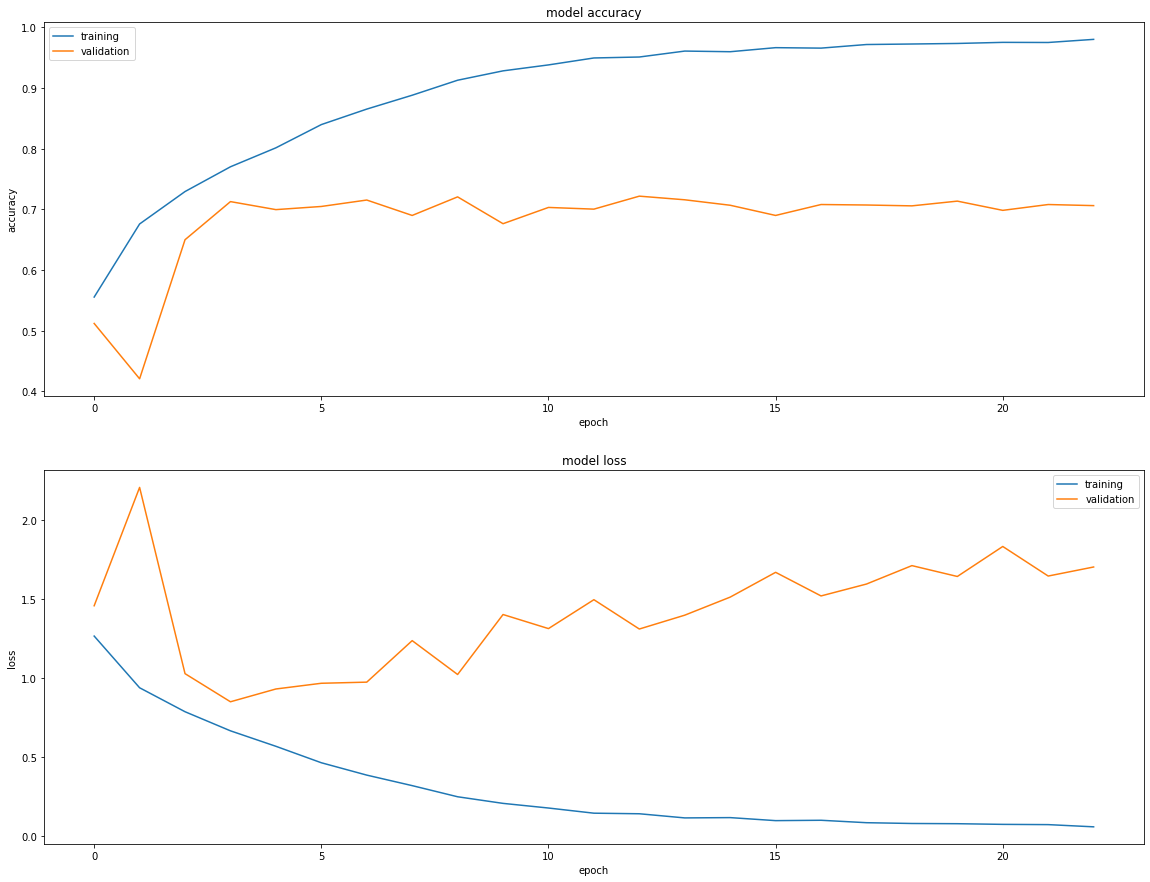

In [160]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_08.history['accuracy'], history_08.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_08.history['loss'], history_08.history['val_loss'], 'loss', 212)

In [161]:
pred08_cm=np.argmax(pred08, axis=1)
print_validation_report(y_test, pred08_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1000
           1       0.75      0.92      0.82      1000
           2       0.57      0.68      0.62      1000
           3       0.57      0.56      0.57      1000
           4       0.72      0.58      0.65      1000
           5       0.66      0.61      0.63      1000
           6       0.89      0.71      0.79      1000
           7       0.64      0.86      0.73      1000
           8       0.82      0.85      0.83      1000
           9       0.92      0.65      0.76      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000

Accuracy Score: 0.7181
Root Mean Square Error: 2.2045180879276085


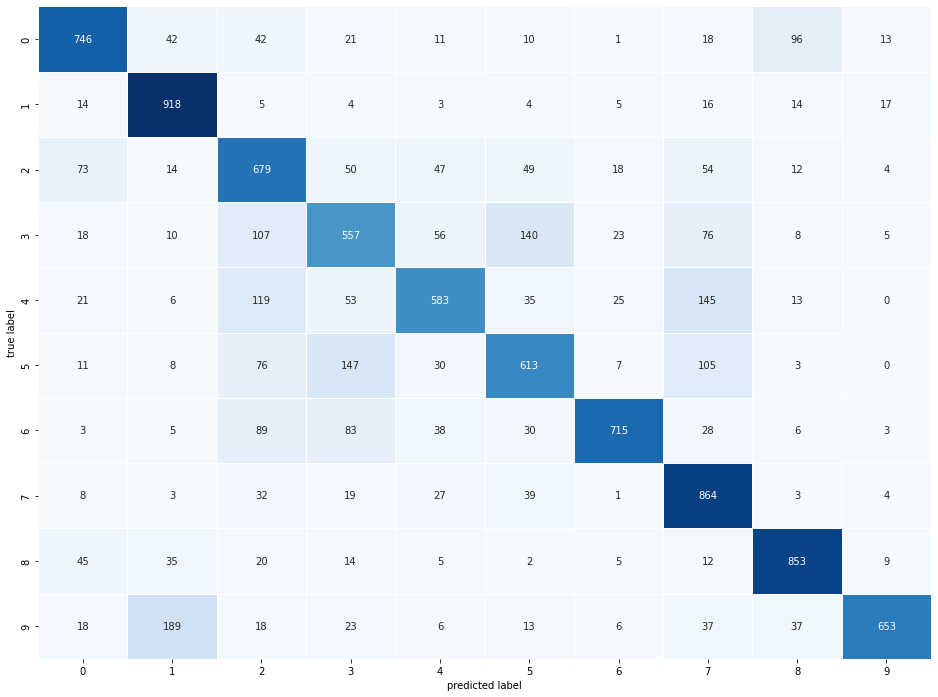

In [162]:
plot_confusion_matrix(y_test,pred08_cm)

In [163]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred08[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.23%,0.59%,0.84%,79.38%,0.04%,12.15%,2.84%,0.40%,3.44%,0.08%
1,0.26%,1.49%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,98.18%,0.07%
2,1.47%,0.88%,0.01%,0.21%,0.01%,0.07%,0.01%,0.12%,95.66%,1.55%
3,64.34%,2.68%,0.06%,0.01%,0.05%,0.00%,0.00%,0.00%,32.83%,0.02%
4,0.00%,0.00%,1.24%,2.34%,1.76%,0.15%,94.48%,0.00%,0.02%,0.00%
5,0.01%,0.08%,0.82%,11.83%,2.24%,8.33%,75.79%,0.87%,0.01%,0.01%
6,0.01%,94.12%,0.03%,0.01%,0.00%,0.02%,0.00%,0.00%,0.00%,5.80%
7,0.03%,0.00%,5.72%,1.77%,14.12%,0.49%,77.84%,0.01%,0.02%,0.00%
8,0.08%,0.01%,2.62%,78.02%,0.26%,15.17%,0.23%,3.60%,0.00%,0.00%
9,0.69%,86.60%,0.01%,0.02%,0.01%,0.02%,0.01%,0.01%,0.05%,12.59%


In [164]:
layer_names = []
for layer in model_08.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dense_1']

In [166]:
# Extracts the outputs of the top 11 layers:
layer_outputs_08 = [layer.output for layer in model_08.layers[:10]]
# Creates a model that will return these outputs, given the model input:
activation_model_08 = tf.keras.models.Model(inputs=model_08.input, outputs=layer_outputs_08)

# Get activation values for the last dense layer
# activations_08 = activation_model_08.predict(x_valid_norm[:3250])
activations_08 = activation_model_08.predict(x_valid_norm[:1200])
dense_layer_activations_08 = activations_08[-3]
output_layer_activations_08 = activations_08[-1]

38/38 [==============================] - 1s 11ms/step


In [167]:
activations_08[-3].shape

(1200, 384)

In [168]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_08 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_08 = tsne_08.fit_transform(dense_layer_activations_08)

# Scaling
tsne_results_08 = (tsne_results_08 - tsne_results_08.min()) / (tsne_results_08.max() - tsne_results_08.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.184s...
[t-SNE] Computed neighbors for 1200 samples in 0.655s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 1.867491


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.946045
[t-SNE] KL divergence after 300 iterations: 1.379066


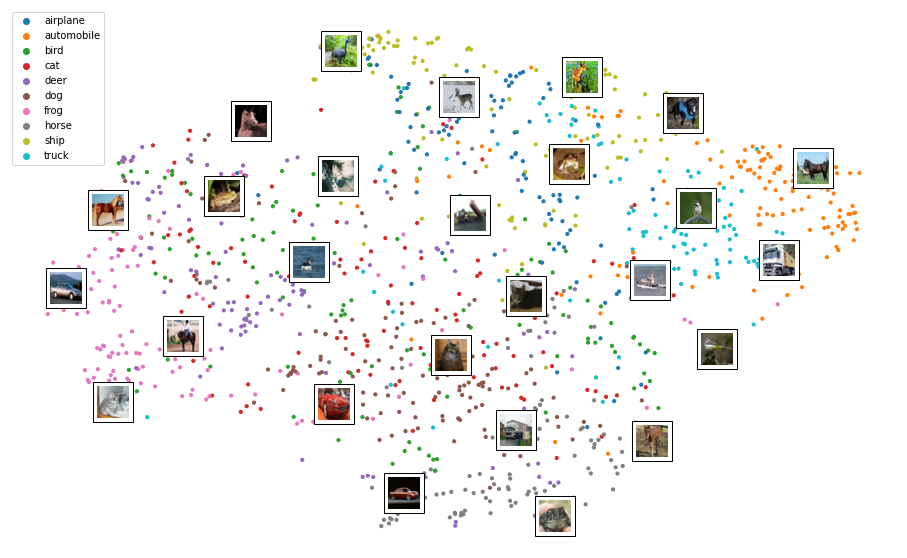

In [169]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_08[:,0],tsne_results_08[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_08[:,0],tsne_results_08[:,1], c=y_valid_split[:1200], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_08):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [170]:
activations_cnn_08 = activation_model_08.predict(img_tensor)
len(activations_cnn_08)

1/1 [==============================] - 0s 262ms/step


10

C:\Users\Reed\AppData\Local\Temp\ipykernel_23184\1165116377.py:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


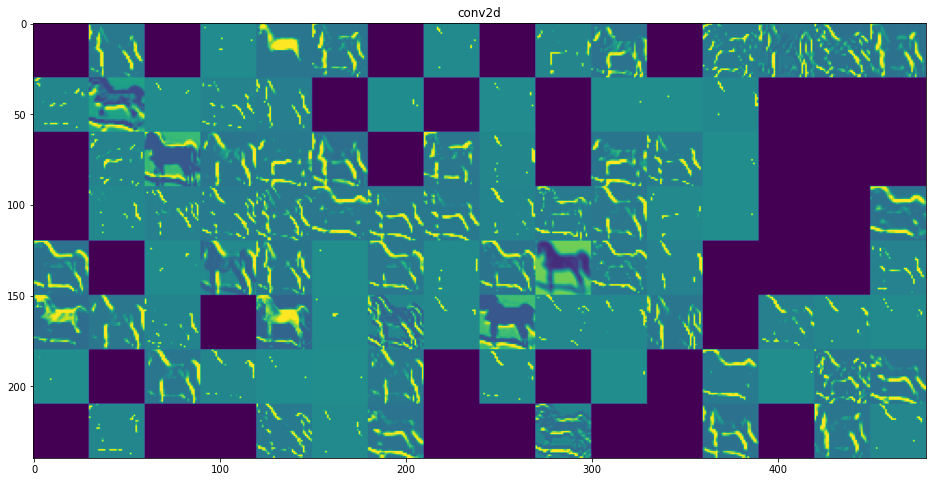

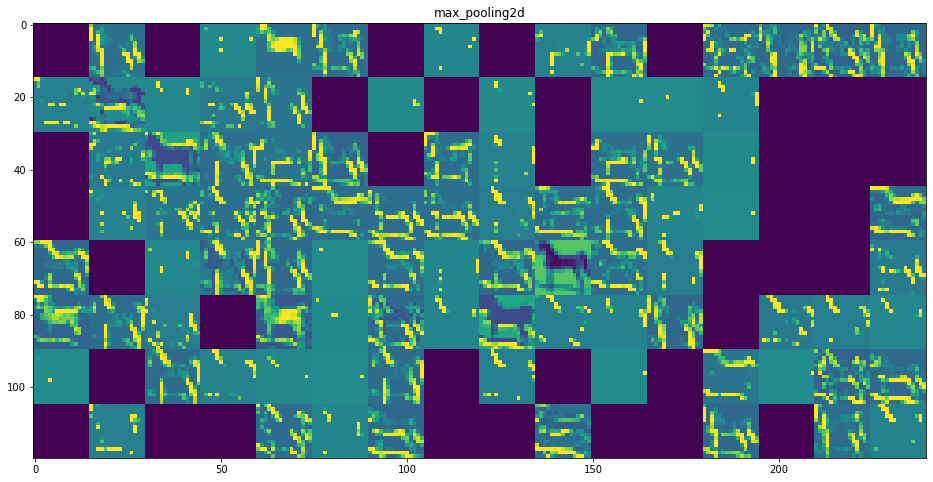

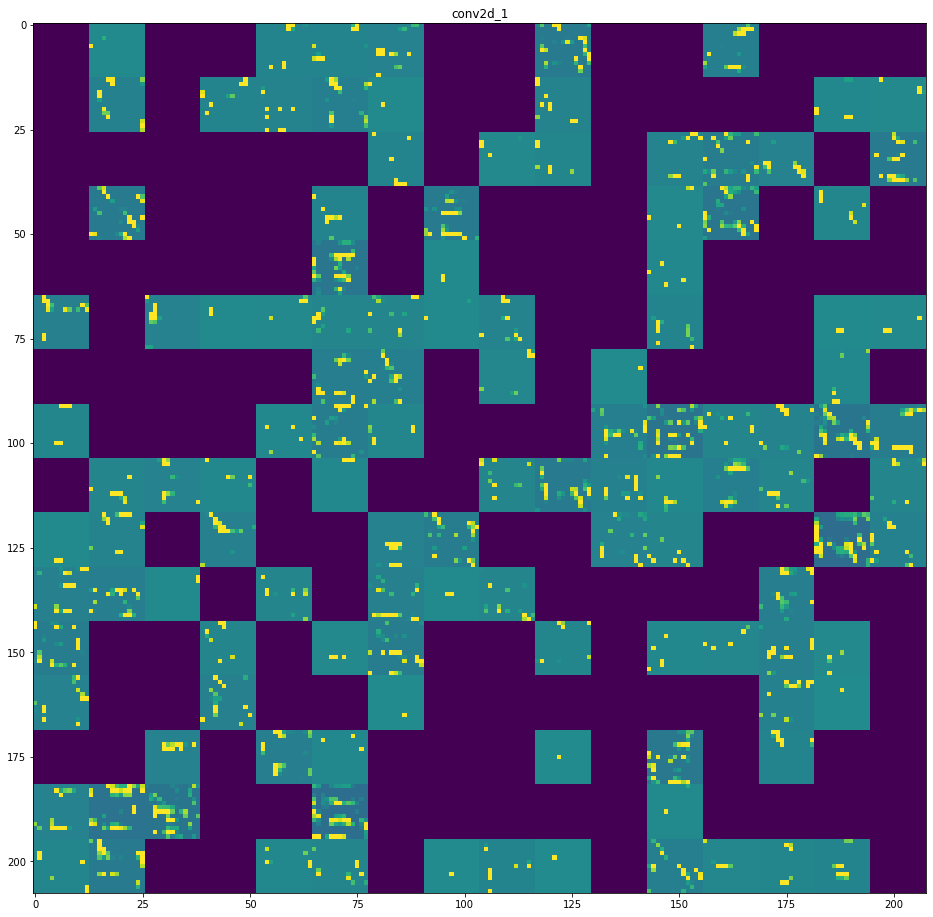

In [171]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_08.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_cnn_08):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();